## BMEG 457 Prototype

This notebook is a prototype of a machine learning pipeline that integrates Shapely values for data valuation.

The diagram below illustrates where the dataset should reside locally for loading it into this notebook. Note that the `data` directory is git ignored.

```markdown
prototype/data/
    ├── train/
    │     ├── NORMAL/
    │     └── PNEUMONIA/
    └── test/
            ├── NORMAL/
            └── PNEUMONIA/
```

Dataset: [chest-xray-dataset](https://www.kaggle.com/datasets/alifrahman/chestxraydataset?resource=download-directory)

In [ ]:
# Standard library imports
import os

# Visualization
import matplotlib.pyplot as plt

# PyTorch and deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, models, transforms

# Set up data paths
data_root = "data"
train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")

print("Train dir:", train_dir)
print("Test dir:", test_dir)

Train dir: data/train
Test dir: data/test


## Image transforms configuration

In [2]:
# ImageNet normalization stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

img_size = 224
batch_size = 32

train_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

eval_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

## Load datasets and make a train/val split

We’ll split the original train folder into train + val (e.g., 80/20).

In [3]:
# Full training dataset (from train_dir)
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
class_names = full_train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names, " | num_classes:", num_classes)

# Test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=eval_transform)

# Train/val split
val_fraction = 0.2
val_size = int(len(full_train_dataset) * val_fraction)
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
print(f"Train size: {train_size}, Val size: {val_size}, Test size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Classes: ['NORMAL', 'PNEUMONIA']  | num_classes: 2
Train size: 4173, Val size: 1043, Test size: 624


## Define MobileNetV2 model for 2 classes

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained MobileNetV2
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Freeze feature extractor for faster training (optional)
for param in base_model.features.parameters():
    param.requires_grad = False

# Replace classifier head
in_features = base_model.classifier[1].in_features
base_model.classifier[1] = nn.Linear(in_features, num_classes)

model = base_model.to(device)

Using device: cpu


## Training & evaluation functions

In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

## Train the model

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

num_epochs = 2  # you can increase later (e.g., 10)

best_val_acc = 0.0
best_state_dict = None

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(
        f"Epoch {epoch + 1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict().copy()

print("Best val accuracy:", best_val_acc)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

Epoch 1/2 | Train Loss: 0.3169 Acc: 0.8692 | Val Loss: 0.1985 Acc: 0.9386
Epoch 2/2 | Train Loss: 0.2004 Acc: 0.9257 | Val Loss: 0.1635 Acc: 0.9406
Best val accuracy: 0.9405560882070949


In [7]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.4455 | Test Acc: 0.7933


## Build a feature extractor from the trained model

In [8]:
# Create a new MobileNetV2 with same architecture and load trained weights
feature_model = models.mobilenet_v2(weights=None)
feature_model.classifier[1] = nn.Linear(feature_model.classifier[1].in_features, num_classes)
feature_model.load_state_dict(model.state_dict())

# Replace classifier with Identity so output is feature embedding
feature_model.classifier = nn.Identity()
feature_model = feature_model.to(device)
feature_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
def get_embeddings(dataloader, model, device):
    all_feats = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            feats = model(images)  # [B, D]
            all_feats.append(feats.cpu())
            all_labels.append(labels)
    return torch.cat(all_feats, dim=0), torch.cat(all_labels, dim=0)

In [10]:
train_feats, train_labels = get_embeddings(
    DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2), feature_model, device
)
val_feats, val_labels = get_embeddings(
    DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2), feature_model, device
)

print("Train feats:", train_feats.shape, "Val feats:", val_feats.shape)

Train feats: torch.Size([4173, 1280]) Val feats: torch.Size([1043, 1280])


## KNN-style data Shapley approximation

In [11]:
# L2 normalize the embeddings for cosine similarity
train_feats_norm = F.normalize(train_feats, p=2, dim=1)  # [N_train, D]
val_feats_norm = F.normalize(val_feats, p=2, dim=1)  # [N_val, D]

N_train = train_feats_norm.shape[0]
N_val = val_feats_norm.shape[0]

data_values = torch.zeros(N_train)

k = 10  # number of neighbors to consider
val_batch_size = 64  # for similarity computations

In [12]:
for start in range(0, N_val, val_batch_size):
    end = min(start + val_batch_size, N_val)
    val_batch = val_feats_norm[start:end]  # [B, D]
    val_labels_batch = val_labels[start:end]  # [B]

    # Cosine similarity to all train samples: [B, N_train]
    sims = val_batch @ train_feats_norm.T

    # Top-k neighbors for each val sample
    topk_sims, topk_idx = torch.topk(sims, k=k, dim=1)

    for b in range(topk_idx.shape[0]):
        v_label = val_labels_batch[b]
        neighbors = topk_idx[b]  # indices in [0, N_train)
        neigh_labels = train_labels[neighbors]

        same = (neigh_labels == v_label).float()
        # +1 for same-label neighbors, -1 for different-label neighbors
        contrib = same * 1.0 - (1.0 - same) * 1.0

        # Optionally weight by similarity:
        # contrib = contrib * topk_sims[b]

        # Average over k and add to data_values
        data_values[neighbors] += contrib / k

print("Data values shape:", data_values.shape)
print("Min value:", data_values.min().item(), "Max value:", data_values.max().item())

Data values shape: torch.Size([4173])
Min value: -1.0000001192092896 Max value: 2.8999993801116943


## Rank training samples and build a reduced training set

In [13]:
sorted_idx = torch.argsort(data_values, descending=True)

# Example: keep top 90% most valuable training samples
keep_fraction = 0.9
keep_n = int(len(sorted_idx) * keep_fraction)

keep_idx = sorted_idx[:keep_n]
drop_idx = sorted_idx[keep_n:]

print("Keeping", keep_n, "out of", len(sorted_idx), "training samples.")

Keeping 3755 out of 4173 training samples.


This next line of code will tell us which pictures are most important and the value of importance assigned to that image by shapley

In [14]:
print(sorted_idx[:11])  # gives the index of image that are most valuable
print(data_values[sorted_idx[:15]])  # gives the value of important images

tensor([3545, 2984, 3459, 3735, 1991, 3881, 2550, 1175, 1794, 1081,  979])
tensor([2.9000, 2.5000, 2.4000, 2.4000, 2.4000, 2.4000, 2.3000, 2.1000, 2.1000,
        2.0000, 2.0000, 1.9000, 1.9000, 1.9000, 1.9000])


In [15]:
reduced_train_dataset = Subset(train_dataset, keep_idx.tolist())
print("Reduced train size:", len(reduced_train_dataset))

reduced_train_loader = DataLoader(reduced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Reduced train size: 3755


In [16]:
def train_model_on_dataset(train_ds, val_ds, num_epochs=5):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    for p in model.features.parameters():
        p.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(
            f"[Reduced] Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
        )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


reduced_model = train_model_on_dataset(reduced_train_dataset, val_dataset, num_epochs=2)
reduced_test_loss, reduced_test_acc = evaluate(reduced_model, test_loader, criterion, device)
print(f"[Reduced] Test Loss: {reduced_test_loss:.4f} | Test Acc: {reduced_test_acc:.4f}")

[Reduced] Epoch 1/2 | Train Loss: 0.2989 Acc: 0.8796 | Val Loss: 0.2120 Acc: 0.9281
[Reduced] Epoch 2/2 | Train Loss: 0.1801 Acc: 0.9366 | Val Loss: 0.1633 Acc: 0.9367
[Reduced] Test Loss: 0.4314 | Test Acc: 0.7917


## Full-dataset model: tracking training & test accuracy

In [17]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.4455 | Test Acc: 0.7933


In [18]:
train_loss, train_acc = evaluate(model, train_loader, criterion, device)
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
full_train_acc = train_acc
full_test_acc = test_acc

Train Loss: 0.1567 | Train Acc: 0.9449


## Reduced-dataset model: tracking training & test accuracy

In [19]:
reduced_train_loss, reduced_train_acc = evaluate(reduced_model, reduced_train_loader, criterion, device)
reduced_test_loss, reduced_test_acc = evaluate(reduced_model, test_loader, criterion, device)

print(f"[Reduced] Train Acc: {reduced_train_acc:.4f}")
print(f"[Reduced] Test Acc: {reduced_test_acc:.4f}")

[Reduced] Train Acc: 0.9617
[Reduced] Test Acc: 0.7917


## Final table

In [20]:
print("\n=== COMPARISON ===")
print(f"Full Data Model:     TrainAcc={full_train_acc:.4f} | TestAcc={full_test_acc:.4f}")
print(f"Reduced Data Model:  TrainAcc={reduced_train_acc:.4f} | TestAcc={reduced_test_acc:.4f}")


=== COMPARISON ===
Full Data Model:     TrainAcc=0.9449 | TestAcc=0.7933
Reduced Data Model:  TrainAcc=0.9617 | TestAcc=0.7917


## Plot 2 points: Full vs Reduced

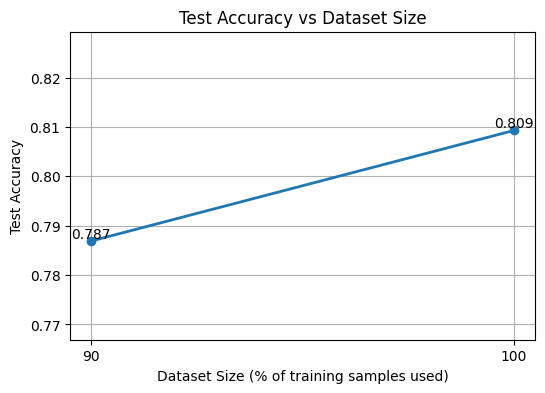

In [21]:
# Replace these with your real results:
acc_full = 0.8093  # test accuracy using 100% of dataset
acc_half = 0.7869  # test accuracy using 90% of high-value images

fractions = [100, 90]
accuracies = [acc_full, acc_half]

plt.figure(figsize=(6, 4))
plt.plot(fractions, accuracies, marker="o", linewidth=2)

plt.title("Test Accuracy vs Dataset Size")
plt.xlabel("Dataset Size (% of training samples used)")
plt.ylabel("Test Accuracy")

plt.xticks([90, 100])
plt.ylim(min(accuracies) - 0.02, max(accuracies) + 0.02)
plt.grid(True)

for x, y in zip(fractions, accuracies):
    plt.text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

plt.show()